<a href="https://colab.research.google.com/github/Vaishnavi6699/Image-Colourisation-using-machine-learning-models/blob/main/colourisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Neural network definition (.prototxt):
!wget -O colorization_deploy_v2.prototxt \
  https://raw.githubusercontent.com/richzhang/colorization/caffe/models/colorization_deploy_v2.prototxt

# 2. Pre-trained weights (.caffemodel):
!wget -O colorization_release_v2.caffemodel \
  https://storage.openvinotoolkit.org/repositories/datumaro/models/colorization/colorization_release_v2.caffemodel

# 3. Color cluster centers (NumPy file):
!wget -O pts_in_hull.npy \
  https://raw.githubusercontent.com/richzhang/colorization/caffe/colorization/resources/pts_in_hull.npy?raw=true


--2025-07-19 10:40:06--  https://raw.githubusercontent.com/richzhang/colorization/caffe/models/colorization_deploy_v2.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9945 (9.7K) [text/plain]
Saving to: ‘colorization_deploy_v2.prototxt’

colorization_deploy 100%[===================>]   9.71K  --.-KB/s    in 0s      

2025-07-19 10:40:06 (77.9 MB/s) - ‘colorization_deploy_v2.prototxt’ saved [9945/9945]

--2025-07-19 10:40:06--  https://storage.openvinotoolkit.org/repositories/datumaro/models/colorization/colorization_release_v2.caffemodel
Resolving storage.openvinotoolkit.org (storage.openvinotoolkit.org)... 18.238.243.83, 18.238.243.81, 18.238.243.89, ...
Connecting to storage.openvinotoolkit.org (storage.openvinotoolkit.org)|18.238.243.83|:443... co

In [ ]:
from google.colab import files

# Upload your grayscale image (JPG, PNG, etc.)
uploaded = files.upload()

# Automatically grab the filename
img_path = list(uploaded.keys())[0]
print("Image uploaded:", img_path)


Saving images.jpeg to images.jpeg
Image uploaded: images.jpeg


In [ ]:
import cv2
import numpy as np

# Load model architecture & weights
net = cv2.dnn.readNetFromCaffe(
    'colorization_deploy_v2.prototxt',
    'colorization_release_v2.caffemodel'
)

# Load color cluster centers and add to model
pts = np.load('pts_in_hull.npy')
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts.astype(np.float32)]
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, dtype=np.float32)]


In [ ]:
import matplotlib.pyplot as plt

# Read and preprocess image
img = cv2.imread(img_path)
h, w = img.shape[:2]
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32') / 255.0
lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
L = lab[:, :, 0]

# Prepare input for model
L_resized = cv2.resize(L, (224, 224)) - 50
net.setInput(cv2.dnn.blobFromImage(L_resized))

# Predict AB channels
ab = net.forward()[0].transpose((1, 2, 0))
ab = cv2.resize(ab, (w, h))

# Merge with L channel and convert back to RGB
lab_out = np.concatenate((L[:, :, np.newaxis], ab), axis=2)
rgb_out = cv2.cvtColor(lab_out.astype('float32'), cv2.COLOR_LAB2RGB)
rgb_out = np.clip(rgb_out, 0, 1)


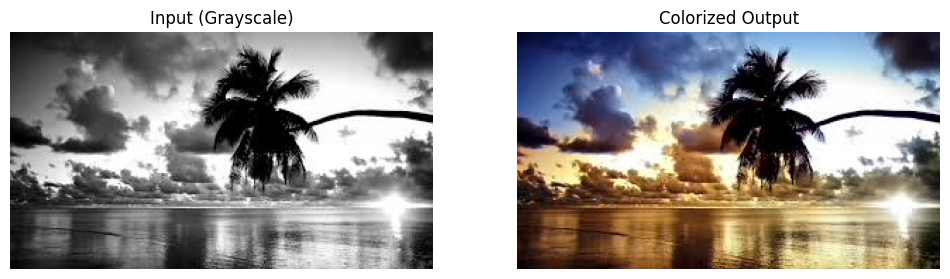

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Input (Grayscale)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow((rgb_out * 255).astype('uint8'))
plt.title('Colorized Output')
plt.axis('off')

plt.show()
